In [19]:
import rasterio
from rasterio import plot
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
import pandas as pd
import cv2 as cv
from ipywidgets import interact, interactive, fixed, interact_manual
import IPython
import ipywidgets as widgets
from PIL import Image

In [2]:
os.chdir(r'C:\Users\user\Downloads\thesis')
os.getcwd()

'C:\\Users\\user\\Downloads\\thesis'

In [40]:
im = [images for images in os.listdir() if images.endswith('tif')]
im

['plotblock.tif']

In [151]:
img = rasterio.open(im[0])
meta = img.meta
meta
image = img.read().transpose(1,2,0)

In [193]:
def rotate_geotiff(src=image,angle=-45):
    '''accepts a multi channel raster and the angle to rotate in degrees. Returns
    raster in channel last shape'''
    ret = 1
    if type(src) == bool: 
        src = image
        ret = True
   
    rows,cols = src.shape[:2]
    m = cv.getRotationMatrix2D((cols/2,rows/2),angle,1)
    rotated = cv.warpAffine(src[:,:,0],m,(cols,rows))                # rotating first channel
    for i in range(1,src.shape[2]):                                # rotating all subsequent channels
        dst = cv.warpAffine(src[:,:,i],m,(cols,rows))
        rotated = np.dstack((rotated,dst))
    del(src)
    if type(ret)==bool:
       
        plt.figure(figsize=(5,5))
        plt.imshow(rotated[:,:,:3])
        
    if type(ret)!= bool:
        return rotated

In [192]:
interact_manual(rotate_geotiff,src=False,angle=widgets.FloatSlider(min=-360,max=360,step=0.1,value=-45))

interactive(children=(Checkbox(value=False, description='src'), FloatSlider(value=-45.0, description='angle', …

<function __main__.rotate_geotiff(src=array([[[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        ...,
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       [[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        ...,
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       [[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        ...,
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       ...,

       [[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        ...,
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       [[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        ...,
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       [[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        ...,
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]]], dtype=uint8), angle=-45)>

In [195]:
rotated = rotate_geotiff(angle=-45.3)

In [202]:
def crop_image(T,L):
    im = rotated
       
    cropped = im[T[0]:T[1],L[0]:L[1],:3]
    plt.figure(figsize=(8,8))
    plt.imshow(cropped)
    
    return cropped
    

In [201]:
cropped=interact_manual(crop_image,
                T=widgets.IntRangeSlider(min=0,max=img.height-1,step=1,value=[0,img.height-1]),
                L=widgets.IntRangeSlider(min=0,max=img.width-1,step=1,value=[0,img.width-1]),
                )

interactive(children=(IntRangeSlider(value=(0, 2624), description='T', max=2624), IntRangeSlider(value=(0, 283…

In [4]:
def compute_nvi(band2,band1):
    vi = np.where(band2+band1==0,0,(band2-band1)/(band2+band1))
    return vi

<ipython-input-6-2ae7cfeab555>:2: RuntimeWarning: invalid value encountered in true_divide
  vi = np.where(band2+band1==0,0,(band2-band1)/(band2+band1))


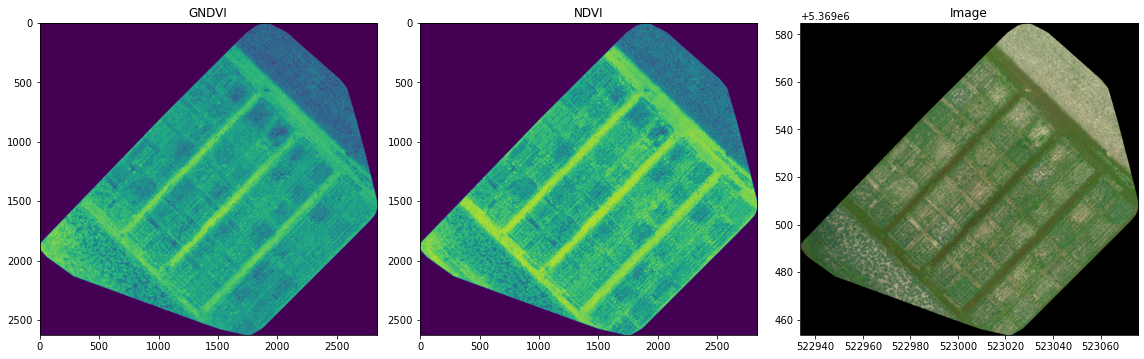

In [7]:
blue = img.read(1).astype('float32')
green = img.read(2).astype('float32')
red = img.read(3).astype('float32')
ir =img.read(4).astype('float32')

fig,ax = plt.subplots(1,3,figsize=(16,6))
gndvi= compute_nvi(ir,green)
plot.show(gndvi,ax=ax[0])
ax[0].set_title('GNDVI')
ndvi= compute_nvi(ir,red)
plot.show(ndvi,ax=ax[1])
ax[1].set_title('NDVI')
plot.show(img,ax=ax[2])
plt.title('Image')
fig.tight_layout()

In [5]:
def plot_hist(im,ignore_ir=True,drop_zeros=True):
    '''plots histogram of an RGB or RGBA image. For RGBA set parameter 'ignore_ir=False'.
    Returns histogram and data frame of the channel values.
    By default drop_zeros is set to True to avoid peaking zero intensities in rasters not cropped to exclude background'''
    
    red = im[:,:,0]
    green = im[:,:,1]
    blue = im[:,:,2]
    
    
    dfb = pd.DataFrame({'value':blue.ravel(),'channel':'blue'})
    dfg = pd.DataFrame({'value':green.ravel(),'channel':'green'})
    dfr = pd.DataFrame({'value':red.ravel(),'channel':'red'})
    if not ignore_ir:
        ir = im[:,:,3]
        dfir = pd.DataFrame({'value':ir.ravel(),'channel':'ir'})
        df = dfb.append(dfg,ignore_index=True).append(dfr,ignore_index=True).append(dfir,ignore_index=True)
        del([dfb,dfg,dfr,dfir])
    else :
        df = dfb.append(dfg,ignore_index=True).append(dfr,ignore_index=True)
        del([dfb,dfg,dfr])
        
    if not drop_zeros :
        data = df
    else :
        data = df[df.value!=0]
    
    return sns.histplot(x='value',hue='channel',hue_order=['blue','red','green'], data=data), df

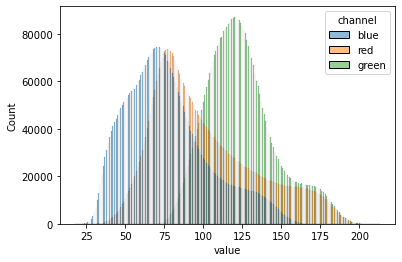

In [106]:
hist,df = plot_hist(img.read().transpose(1,2,0))

<AxesSubplot:xlabel='value', ylabel='Count'>

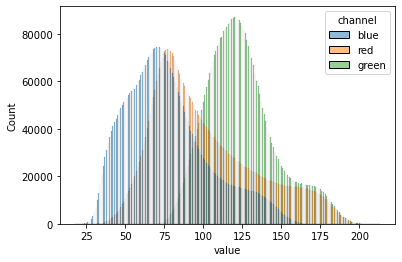

In [107]:
#the same plot can be plotted using the dataframe returned as shown below
sns.histplot(x='value',hue='channel',hue_order=['blue','red','green'],data=df.query("channel!='ir' and value>0"))

In [251]:
df.groupby('channel').describe()

value                                                       
             count        mean         std  min  25%    50%    75%    max
channel                                                                  
blue     7449750.0   58.542725   56.216702  0.0  0.0   68.0   99.0  213.0
green    7449750.0   72.292969   64.787796  0.0  0.0  101.0  125.0  209.0
ir       7449750.0  148.426544  124.135201  0.0  0.0  255.0  255.0  255.0
red      7449750.0   44.560234   43.195431  0.0  0.0   48.0   77.0  173.0

In [96]:
def make_df(plots):
    '''construct a dataframe with the descriptive stats for each of the plots'''
    low,high,avg,std =[],[],[],[]
    for i in range(len(plots)):
        low.append(plots[i].min())
        high.append(plots[i].max())
        avg.append(plots[i].mean())
        std.append(plots[i].std())


    df = pd.DataFrame({'plot':range(1,len(plots)+1),'low':low,'high':high,'avg':avg,'sd':std})
    return df

def make_grids(shape,height,width):
    '''function to create overlaying grids to visualize the plots in the image'''
    grid = np.ones((shape[0],shape[1],3))
    grid[0::height,:]=np.array([1,0,0])
    grid[:,0::width]=np.array([1,0,0])
    return grid

def make_plots(im,width=100,height=100,horizontally=True,):
    '''parses the passed numpy image in channel last form into plots of desired width and height
    returns plots,dataframe of descriptive stats of plots and the grid of the plots'''
    if horizontally == False:
        try :
            im = im.transpose(1,0,2)
        except : im = im.T
    plots = []
    row = 0
    col = 0
    while row <im.shape[0]:
        #nrr =row/height
        while col <im.shape[1]:
            plots.append(im[row:row+height,col:col+width])
            col = col + width
        #nrc = col/width
        col = 0
        row = row + height
    df = make_df(plots) 
    
    grid = make_grids(im.shape[0:2],height,width)
    return plots,df,grid,im

<ipython-input-203-4e2f1e785049>:14: RuntimeWarning: divide by zero encountered in true_divide
  plt.imshow(src_/grid)                           # showing background field below the grid indicating the plot boundary
<ipython-input-203-4e2f1e785049>:14: RuntimeWarning: invalid value encountered in true_divide
  plt.imshow(src_/grid)                           # showing background field below the grid indicating the plot boundary


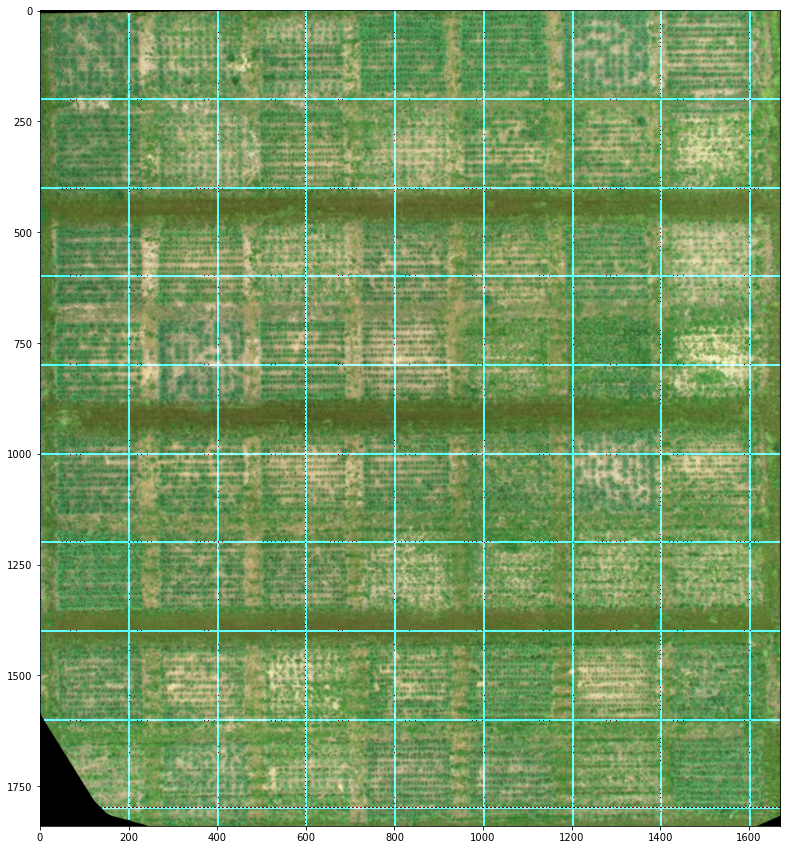

In [203]:
# must pass a numpy object with one channel not rasterio object or numpy with 3 channels

src = img.read().transpose(1,2,0)               # converting from channel first to channel last
rotated = rotate_geotiff(src,-45.3)             # rotating to make the plot rectangular
cropped = rotated[670:2510,580:2250,:]          # cropping to exclude non-interest regions

plots,df,grid,src = make_plots(cropped,200,200) # creating raster of plots from input raster, grid of plots

plt.figure(figsize=(15,15))

src_ = src[:,:,:3].astype('float32')            # converting to float to prevent rounding off to integeres in raster calculations
src_ = src_/(src_.max()-src_.min())             # normalizing raster for combining with grid

plt.imshow(src_/grid)                           # showing background field below the grid indicating the plot boundary

In [168]:
src = img.read().transpose(1,2,0)   

def plot_partition(height,width):
    '''function to create overlaying grids to visualize the plots in the image'''
    #src=np.array(im)
    grid = np.ones((cropped.shape[0],cropped.shape[1],3))
    grid[0::height,:]=np.array([1,0,0])
    grid[:,0::width]=np.array([1,0,0])
    src_= src[:,:,:3].astype('float32')    
    src_= src_/(src_.max()-src_.min())     
    plt.figure(figsize=(10,10))              
      
    return plt.imshow(src_/grid)

In [167]:
interact_manual(plot_partition,height=widgets.IntSlider(min=1, max=1000, step=1, value=100),
         width=widgets.IntSlider(min=1, max=1000, step=1, value=100));

interactive(children=(IntSlider(value=100, description='height', max=1000, min=1), IntSlider(value=100, descri…

<Figure size 720x720 with 0 Axes>

In [ ]:
src_= src[:,:,:3].astype('float32')    
src_= src_/(src_.max()-src_.min())     
plt.figure(figsize=(6,6))              
plt.imshow(src_/grid)             

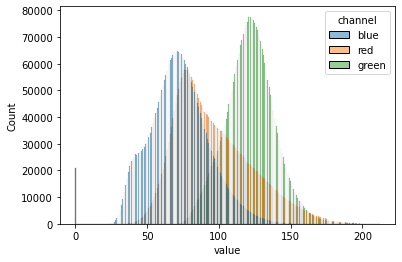

In [17]:
hist,h_df = plot_hist(src)

In [19]:
h_df.groupby('channel').describe()

value                                                        
             count        mean        std  min    25%    50%    75%    max
channel                                                                   
blue     3056100.0   71.988439  21.013750  0.0   58.0   71.0   85.0  169.0
green    3056100.0  120.948187  19.771377  0.0  110.0  122.0  132.0  209.0
red      3056100.0   95.647370  27.842080  0.0   76.0   91.0  113.0  212.0

<ipython-input-6-2ae7cfeab555>:2: RuntimeWarning: invalid value encountered in true_divide
  vi = np.where(band2+band1==0,0,(band2-band1)/(band2+band1))


Text(0.5, 1.0, 'original')

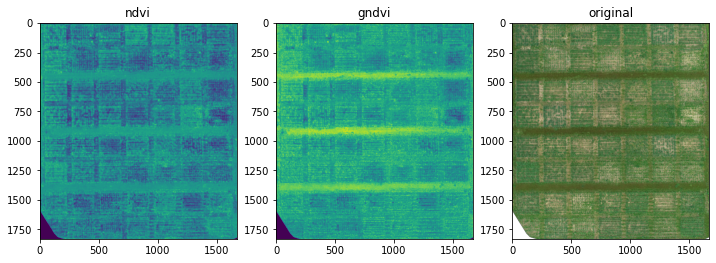

In [87]:
fig,ax = plt.subplots(1,3,figsize=(12,5))
src_ =src.astype('float32')
ndvi = compute_nvi(src_[:,:,3],src_[:,:,0])
gndvi = compute_nvi(src_[:,:,3],src_[:,:,1])

ax[0].imshow(ndvi)
ax[0].set_title('ndvi')

ax[1].imshow(gndvi)
ax[1].set_title('gndvi')

ax[2].imshow(src)
ax[2].set_title('original')

#plt.colorbar()

<ipython-input-99-c31ababce62e>:2: RuntimeWarning: divide by zero encountered in true_divide
  plt.imshow(g_src/g_grid[:,:,1])
<ipython-input-99-c31ababce62e>:2: RuntimeWarning: invalid value encountered in true_divide
  plt.imshow(g_src/g_grid[:,:,1])


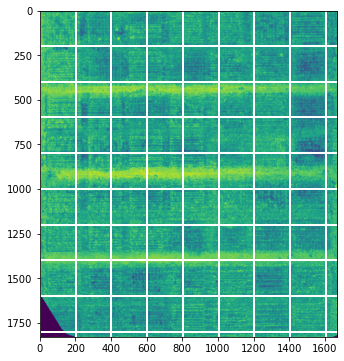

In [99]:
plots,gdf,g_grid,g_src = make_plots(gndvi,200,200)
plt.figure(figsize=(6,6))
plt.imshow(g_src/g_grid[:,:,1])

In [89]:
gdf.describe()

,plot,low,high,avg,sd
count,90.000000,90.000000,90.000000,90.000000,90.000000
mean,45.500000,0.169153,0.526749,0.351121,0.055723
std,26.124701,0.061845,0.031320,0.043059,0.019043
min,1.000000,0.000000,0.425743,0.060493,0.037525
25%,23.250000,0.156463,0.508876,0.336876,0.043904
50%,45.500000,0.183295,0.526946,0.349836,0.050205
75%,67.750000,0.202830,0.545455,0.374164,0.063334
max,90.000000,0.259259,0.600000,0.423085,0.161208


<AxesSubplot:>

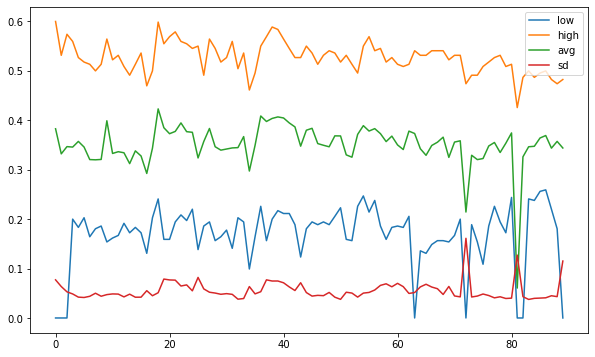

In [90]:
gdf[['low', 'high', 'avg', 'sd']].plot(figsize=(10,6))

<AxesSubplot:>

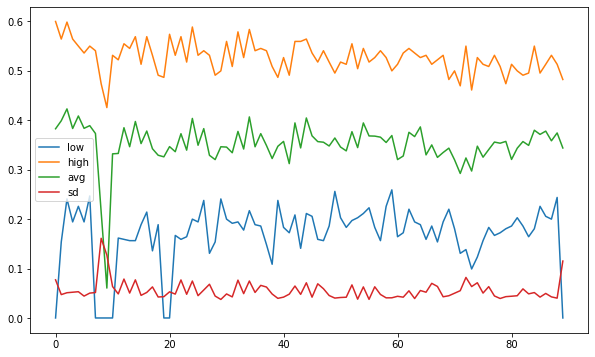

In [91]:
plots,gdf,g_grid,g_src = make_plots(gndvi,200,200,False)

gdf[['low', 'high', 'avg', 'sd']].plot(figsize=(10,6))